# **Analysis of decoding results**

## **Libraries**

In [148]:
#%pip install pandas matplotlib seaborn nltk sacrebleu

In [149]:
import os
import warnings

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import nltk
import sacrebleu

import constants

## **Directories**

In [150]:
RESULTS_FOLDER = constants.RESULTS_DATA_FOLDER
INSPECTED_FOLDER = constants.INSPECTED_DATA_FOLDER
DECODED_OUTPUTS_FOLDER = constants.DECODED_OUTPUTS_FOLDER

DECODED_OUTPUTS_FILENAME = 'model_translation_sp16_gn_es.txt' #'split_decode_checkpoint_100-80.log'#'first_decode_checkpoint_100-50.log'#
DECODED_OUTPUTS_FILEPATH = os.path.join(DECODED_OUTPUTS_FOLDER, DECODED_OUTPUTS_FILENAME)
REFERENCE_SOURCE_FILENAME = 'valid_gn.txt.gn' #'first_val_gn.txt'#
REFERENCE_SOURCE_FILEPATH = os.path.join(INSPECTED_FOLDER, REFERENCE_SOURCE_FILENAME)
REFERENCE_DESTINATION_FILENAME = 'valid_es.txt.es' #'first_val_es.txt'#
REFERENCE_DESTINATION_FILEPATH = os.path.join(INSPECTED_FOLDER, REFERENCE_DESTINATION_FILENAME)
DECODING_RESULTS_FOLDER = os.path.join(RESULTS_FOLDER, 'decoded_outputs_first_sp16')
CURRENT_RESULTS_FOLDER = os.path.join(DECODING_RESULTS_FOLDER, DECODED_OUTPUTS_FILENAME.split('.')[0])

if not os.path.exists(DECODING_RESULTS_FOLDER):
    os.makedirs(DECODING_RESULTS_FOLDER)

if not os.path.exists(CURRENT_RESULTS_FOLDER):
    os.makedirs(CURRENT_RESULTS_FOLDER)

In [151]:
with open(REFERENCE_SOURCE_FILEPATH, 'r', encoding='utf-8') as f:
    reference_source_gn = f.readlines()

with open(REFERENCE_DESTINATION_FILEPATH, 'r', encoding='utf-8') as f:
    reference_destination_es = f.readlines()

with open(DECODED_OUTPUTS_FILEPATH, 'r', encoding='utf-8') as f:
    decoded_outputs = f.readlines()

## **Checking files**

In [152]:
print(f'Number of lines in reference source: {len(reference_source_gn)}')
print(f'Number of lines in reference destination: {len(reference_destination_es)}')
print(f'Number of lines in decoded outputs: {len(decoded_outputs)}')

Number of lines in reference source: 5310
Number of lines in reference destination: 5310
Number of lines in decoded outputs: 5309


There is a difference of 1 between the number of lines in the decoded outputs and the number of lines in the original inputs.

In [153]:
for idx, (elem_ref, elem_dest, decoded) in enumerate(zip(reference_source_gn, reference_destination_es, decoded_outputs)):
    if elem_ref.strip() == '':
        print(f'Empty line at index {idx} from reference source')

    if elem_dest.strip() == '':
        print(f'Empty line at index {idx} from reference destination')

    if decoded.strip() == '':
        print(f'Empty line at index {idx} from decoded outputs')

Empty line at index 1650 from decoded outputs
Empty line at index 3982 from decoded outputs
Empty line at index 4246 from decoded outputs
Empty line at index 4572 from decoded outputs


This extra line is not a problem, as the decoded file can output empty lines. However, it remains unclear why the length of the files are different.

## **Score analysis**

### **Examples of BLEU score**

In [154]:
def silence_warnings(func):
    def wrapper(*args, **kwargs):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            return func(*args, **kwargs)
    return wrapper

In [155]:
correct_reference = 'Today is a new day'
short_reference = 'Today'
wrong_reference = 'Yesterday was a good day'

translated = 'Today is a new day'

### **Classic BLEU**

In [156]:
@silence_warnings
def calculate_bleu(reference, translated, bleu_score_type='sacrebleu'):
    chrf_function = lambda reference, translated: sacrebleu.sentence_chrf(translated, [reference]).score
    sacrebleu_function = lambda reference, translated: sacrebleu.sentence_bleu(translated, [reference]).score
    
    score_functions = {
        'chrf': chrf_function,
        'sacrebleu': sacrebleu_function
    }

    bleu_score = score_functions[bleu_score_type](reference, translated)
    return bleu_score

In [157]:
def create_bleu_scores_df(references, translated, bleu_score_types):
    bleu_scores_df = {'reference': [], 'translation': [], 'metric': [], 'score': []}

    for reference, translation in zip(references, translated):
        for bleu_score_type in bleu_score_types:
            bleu_score = calculate_bleu(reference, translation, bleu_score_type=bleu_score_type)
            bleu_scores_df['reference'].append(reference)
            bleu_scores_df['translation'].append(translation)
            bleu_scores_df['metric'].append(bleu_score_type)
            bleu_scores_df['score'].append(bleu_score)

    return pd.DataFrame(bleu_scores_df)

#### **Test examples**

In [158]:
example_dfs = []

example_references = [correct_reference, short_reference, wrong_reference]
bleu_scores_example_df = create_bleu_scores_df(
    example_references, 
    [translated]*len(example_references), 
    bleu_score_types=['chrf', 'sacrebleu']
)
example_dfs.append(bleu_scores_example_df)

example_dfs = pd.concat(example_dfs)
example_dfs.style.format({'score': '{:.5g}'})

,reference,translation,metric,score
0,Today is a new day,Today is a new day,chrf,100
1,Today is a new day,Today is a new day,sacrebleu,100
2,Today,Today is a new day,chrf,61.137
3,Today,Today is a new day,sacrebleu,10.682
4,Yesterday was a good day,Today is a new day,chrf,17.354
5,Yesterday was a good day,Today is a new day,sacrebleu,12.703


In [159]:
def calculate_chrf(reference, translated):
    chrf_score = sacrebleu.corpus_chrf(translated, [reference]).score
    return chrf_score

reference = 'Today is a ne day'
translated = 'Today is a new day'

chrf_score = calculate_chrf(reference, translated)
print(f'CHRF score: {chrf_score}')

CHRF score: 78.125


### **BLEU score distribution**

In [160]:
bleu_scores_df = create_bleu_scores_df(
    reference_destination_es,
    decoded_outputs,
    bleu_score_types=['chrf', 'sacrebleu']
)

In [161]:
save_path = os.path.join(CURRENT_RESULTS_FOLDER, 'bleu_scores.csv')
bleu_scores_df.to_csv(save_path, index=False)

In [162]:
for metric in bleu_scores_df['metric'].unique():
    print(f'Metric: {metric}')
    print(bleu_scores_df[bleu_scores_df['metric'] == metric].describe())
    print()

save_path = os.path.join(CURRENT_RESULTS_FOLDER, 'bleu_scores_summary.csv')
bleu_scores_df.groupby(['metric']).describe().to_csv(save_path)

Metric: chrf
             score
count  5309.000000
mean     33.322892
std      18.822155
min       0.000000
25%      18.057308
50%      31.395169
75%      45.858288
max     100.000000

Metric: sacrebleu
             score
count  5309.000000
mean     14.274823
std      15.427310
min       0.000000
25%       4.007645
50%       8.449918
75%      19.716119
max     100.000000



This does not align with the BLEU score returned by marian.

TODO: Sentences shorter than 4 words are not well-suited for BLEU scoring.

In [163]:
def plot_scores(ax, scores, titles, xlabel, save_path=None, color='blue'):
    sns.set_style('darkgrid')
    for idx, (score, title) in enumerate(zip(scores, titles)):
        current_ax = ax[idx] if len(scores) > 1 else ax
        sns.kdeplot(score, fill=True, ax=current_ax, color=color)
        current_ax.set(xlabel=xlabel, ylabel='Density', title=title)

    if save_path is not None:
        plt.savefig(save_path)
        sns.set_style('darkgrid')

In [164]:
def plot_thresholded_scores(scores, titles, xlabels, acceptance_thresholds, negligible_thresholds, save_path=None, colors=['blue']):
    non_negligible_scores = []
    acceptable_scores = []
    
    for score, acceptance_threshold, negligible_threshold in zip(scores, acceptance_thresholds, negligible_thresholds):
        non_negligible_scores.append([s for s in score if s > negligible_threshold])
        acceptable_scores.append([s for s in score if s > acceptance_threshold])

    plotted_scores = list(zip(scores, non_negligible_scores, acceptable_scores))

    ncols = len(plotted_scores[0])
    nrows = len(scores)

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 6*nrows))
    fig.suptitle(f'{" - ".join(xlabels)} scores', fontsize=20)
    for idx, (score, title, xlabel, color) in enumerate(zip(plotted_scores, titles, xlabels, colors)):
        current_ax = ax[idx] if nrows > 1 else ax
        plot_scores(current_ax, score, title, xlabel, color=color)
    if save_path is not None:
        plt.savefig(save_path)

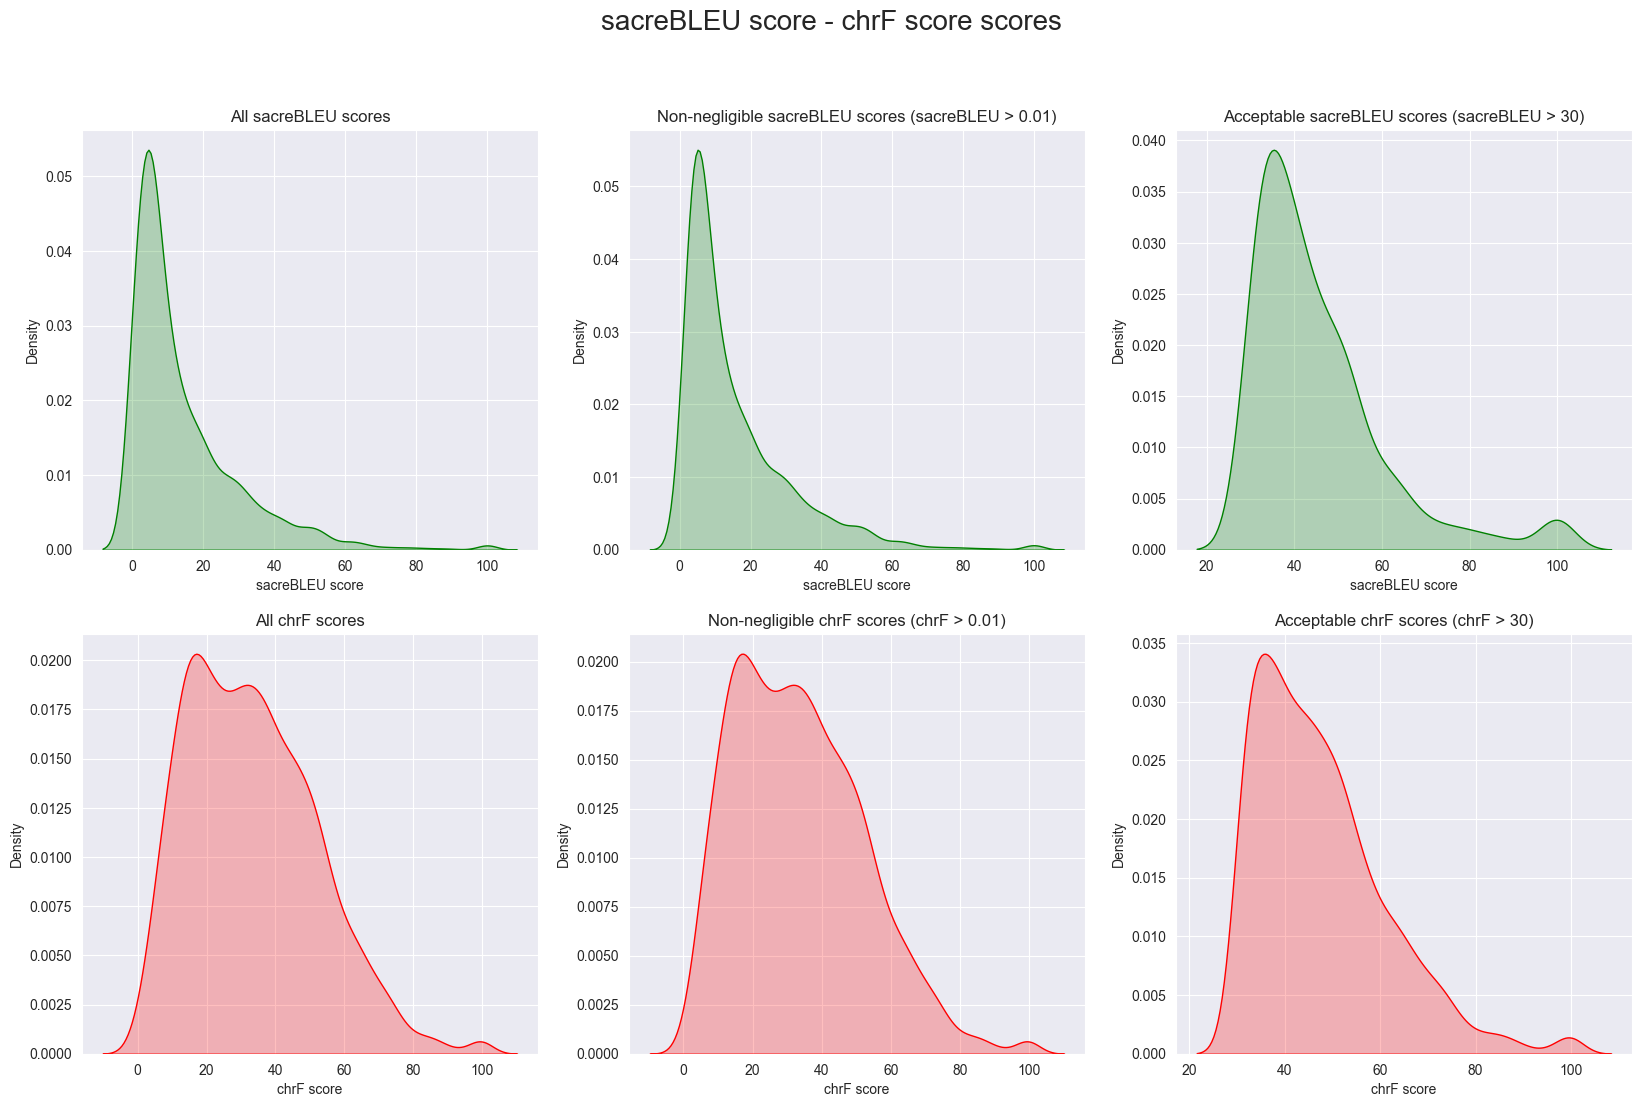

In [165]:
sacrebleu_scores    = bleu_scores_df[bleu_scores_df['metric'] == 'sacrebleu']['score']
chrf_scores         = bleu_scores_df[bleu_scores_df['metric'] == 'chrf']['score']
scores = [sacrebleu_scores, chrf_scores]

acceptance_thresholds = [30, 30]
epsilons = [0.01, 0.01]
save_path = os.path.join(CURRENT_RESULTS_FOLDER, 'bleu_scores.png')

sacrebleu_titles = ['All sacreBLEU scores', f'Non-negligible sacreBLEU scores (sacreBLEU > {epsilons[0]})', f'Acceptable sacreBLEU scores (sacreBLEU > {acceptance_thresholds[0]})']
chrf_titles = ['All chrF scores', f'Non-negligible chrF scores (chrF > {epsilons[1]})', f'Acceptable chrF scores (chrF > {acceptance_thresholds[1]})']
titles = [sacrebleu_titles, chrf_titles]
xlabels = ['sacreBLEU score', 'chrF score']
colors = ['green', 'red']

plot_thresholded_scores(scores, titles, xlabels, acceptance_thresholds, epsilons, save_path=save_path, colors=colors)

### **Best BLEU scores**

In [166]:
def get_ordered_score_indexes(scores, best=True, limit=3):
    return sorted(range(len(scores)), key=lambda i: scores[i], reverse=best)[:limit]

def show_translations(indexes, reference_source, reference_destination, decoded_outputs, save_path=None):

    printed_messages = []
    for idx in indexes:
        reference_destination_tokens = set(reference_destination[idx].strip().split(' '))
        decoded_output_tokens = set(decoded_outputs[idx].strip().split(' '))
        overlapping_words = reference_destination_tokens.intersection(decoded_output_tokens)
        
        printed_message = [
            f'Index: {idx}',
            f'Reference source: {reference_source[idx][:-1]}',
            f'Reference destination: {reference_destination[idx][:-1]}',
            f'Decoded output: {decoded_outputs[idx]}',
            f'Reference destination tokens: {reference_destination_tokens}',
            f'Decoded output tokens: {decoded_output_tokens}',
            f'Overlapping words: {overlapping_words}',
            '------------------'
        ]
        printed_messages.append('\n'.join(printed_message))

    for message in printed_messages:
        print(message)

    if save_path is not None:
        with open(save_path, 'w', encoding='utf-8') as f:
            f.write('\n\n'.join(printed_messages))

In [167]:
best_indexes = get_ordered_score_indexes(list(sacrebleu_scores), best=True, limit=10)
save_dir = os.path.join(CURRENT_RESULTS_FOLDER, 'best_translations.txt')
show_translations(best_indexes, reference_source_gn, reference_destination_es, decoded_outputs, save_path=save_dir)

Index: 3582
Reference source: Taupéicha...
Reference destination: Amén...
Decoded output: Amén...

Reference destination tokens: {'Amén...'}
Decoded output tokens: {'Amén...'}
Overlapping words: {'Amén...'}
------------------
Index: 3925
Reference source: Embotyꞌo
Reference destination: Abrir
Decoded output: Abrir

Reference destination tokens: {'Abrir'}
Decoded output tokens: {'Abrir'}
Overlapping words: {'Abrir'}
------------------
Index: 3943
Reference source: Arandukaporupyre
Reference destination: Bibliografía
Decoded output: Bibliografía

Reference destination tokens: {'Bibliografía'}
Decoded output tokens: {'Bibliografía'}
Overlapping words: {'Bibliografía'}
------------------
Index: 3945
Reference source: Erova
Reference destination: Cambiar
Decoded output: Cambiar

Reference destination tokens: {'Cambiar'}
Decoded output tokens: {'Cambiar'}
Overlapping words: {'Cambiar'}
------------------
Index: 3946
Reference source: Emboty ovetã
Reference destination: Cerrar ventana
Decoded

In [168]:
best_indexes = get_ordered_score_indexes(list(chrf_scores), best=True, limit=10)
#save_dir = os.path.join(CURRENT_RESULTS_FOLDER, 'best_translations.txt')
show_translations(best_indexes, reference_source_gn, reference_destination_es, decoded_outputs, save_path=None)

Index: 548
Reference source: Péicha avei Juan Carlos Muñoz, presidente Centro de Armadores Fluviales y Maritimos del Paraguay, ombojoapy permiso poteî jasy buque osyryry jey haguã.
Reference destination: Por su parte, Juan Carlos Muñoz, presidente del Centro de Armadores Fluviales y Maritimos del Paraguay, añadió que el permiso es por seis meses, a fin de que el buque siga su curso.
Decoded output: Por su parte, Juan Carlos Muñoz, presidente del Centro de ArmadoresFluviales y Maritimos del Paraguay, añadió que el permiso es por seis meses, a fin de que el buque siga su curso.

Reference destination tokens: {'el', 'es', 'que', 'a', 'buque', 'Armadores', 'parte,', 'seis', 'Paraguay,', 'Por', 'meses,', 'y', 'su', 'añadió', 'del', 'Juan', 'Muñoz,', 'por', 'siga', 'fin', 'presidente', 'de', 'Maritimos', 'curso.', 'Carlos', 'Fluviales', 'permiso', 'Centro'}
Decoded output tokens: {'el', 'es', 'que', 'a', 'buque', 'parte,', 'seis', 'Paraguay,', 'Por', 'meses,', 'y', 'su', 'añadió', 'del', 'Ju

In [169]:
worst_indexes = get_ordered_score_indexes(list(sacrebleu_scores), best=False)
show_translations(worst_indexes, reference_source_gn, reference_destination_es, decoded_outputs)

Index: 73
Reference source: Apañuãi mbytépe impuesto jehupi
Reference destination: EN MEDIO DE POLÉMICA POR LA SUBA DE IMPUESTOS
Decoded output: Problemas del impuesto

Reference destination tokens: {'POLÉMICA', 'DE', 'EN', 'LA', 'MEDIO', 'POR', 'SUBA', 'IMPUESTOS'}
Decoded output tokens: {'del', 'Problemas', 'impuesto'}
Overlapping words: set()
------------------
Index: 79
Reference source: Bomba pu omosarambi tata CDE gotyo
Reference destination: Petardo causa incendio
Decoded output: Protección en CDE

Reference destination tokens: {'causa', 'incendio', 'Petardo'}
Decoded output tokens: {'en', 'CDE', 'Protección'}
Overlapping words: set()
------------------
Index: 97
Reference source: Ojerúre umi mbo'ehao ohejávo Gobernación oadministráva
Reference destination: Piden que escuela deje de ser administrada por Gobernación
Decoded output: Exigen los colegios

Reference destination tokens: {'por', 'que', 'deje', 'ser', 'Gobernación', 'de', 'escuela', 'administrada', 'Piden'}
Decoded outp

In [170]:
worst_indexes = get_ordered_score_indexes(list(chrf_scores), best=False)
show_translations(worst_indexes, reference_source_gn, reference_destination_es, decoded_outputs)

Index: 1650
Reference source: Ojejeruréma oñemosê haguã Carmelo PLRA-gui
Reference destination: Solicitan expulsión de Carmelo del PLRA
Decoded output: 

Reference destination tokens: {'expulsión', 'de', 'Carmelo', 'Solicitan', 'PLRA', 'del'}
Decoded output tokens: {''}
Overlapping words: set()
------------------
Index: 3484
Reference source: Y ARAPYGUA ÁRA
Reference destination: DÍA MUNDIAL DEL AGUA
Decoded output: Herramientas

Reference destination tokens: {'AGUA', 'DEL', 'MUNDIAL', 'DÍA'}
Decoded output tokens: {'Herramientas'}
Overlapping words: set()
------------------
Index: 3966
Reference source: Paꞌary
Reference destination: Década
Decoded output: Siglo

Reference destination tokens: {'Década'}
Decoded output tokens: {'Siglo'}
Overlapping words: set()
------------------


### **¿What about the missing line?**

In [171]:
def plot_values_by_index(title, values, color=None):
    sns.set_style('darkgrid')
    x = list(range(len(values)))
    y = values
    plt.title(title)
    plt.plot(x, y, color=color)
    plt.show()

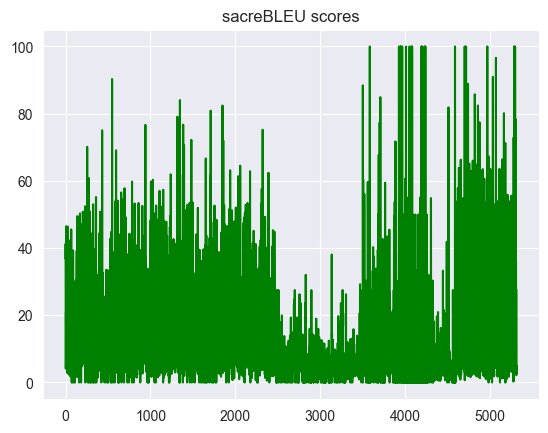

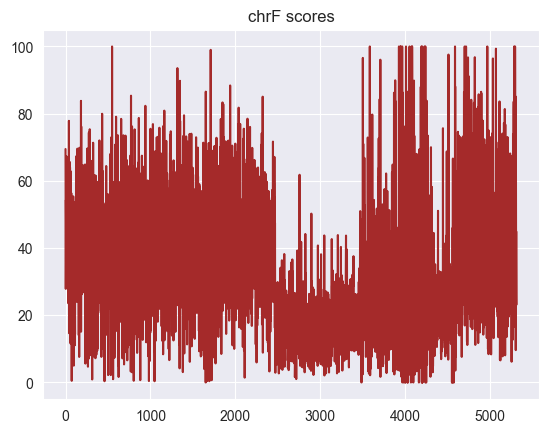

In [172]:
plot_values_by_index('sacreBLEU scores', sacrebleu_scores, color='green')
plot_values_by_index('chrF scores', chrf_scores, color='brown')